# How to handle Rare Labels

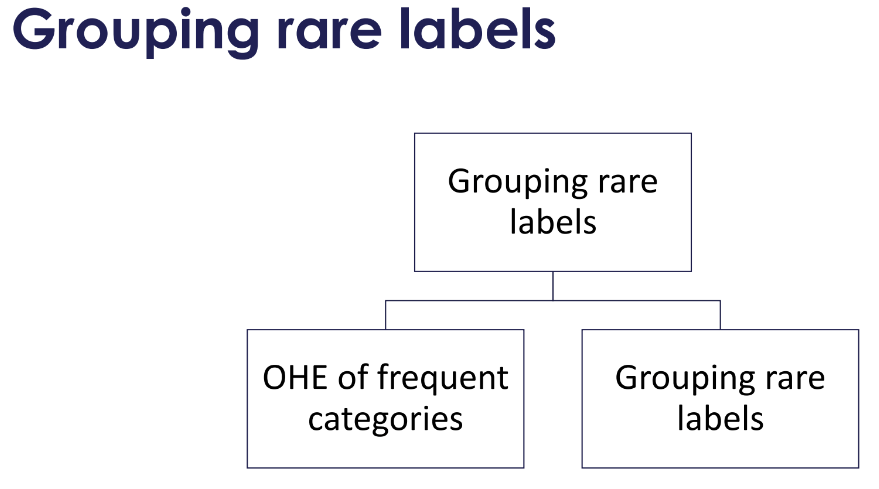

# OHE with frequent categories

**Advantages of OHE of top categories**
* Straightforward to implement
* Does not require hrs of variable exploration
* Does not expand massively the feature space
* Suitable for linear models

**Limitations**
* Does not add any information that may make the variable more predictive
* Does not keep the information of the ignored labels

## OHE with pandas and NumPy
**Advantages**
* quick
* returns pandas dataframe
* returns feature names for the dummy variables

**Limitations:**
* it does not preserve information from train data to propagate to test data

In [ ]:
# Step 1: Find the top 10 most frequent categories for 'Neighborhood'
# Displays the top 10 categories with the highest frequency in the training data.
X_train["Neighborhood"].value_counts().sort_values(ascending=False).head(10)

# Step 2: Create a list of the most frequent categories
# Extracts the top 10 most frequent category names from the training data.
top_10 = [x for x in X_train["Neighborhood"].value_counts().sort_values(ascending=False).head(10).index]

# Step 3: Create binary variables for the top 10 categories
# Adds binary columns to represent the presence of each top 10 category in the training and testing data.
for label in top_10:
    X_train["Neighborhood" + "_" + label] = np.where(
        X_train["Neighborhood"] == label, 1, 0
    )

    X_test["Neighborhood" + "_" + label] = np.where(
        X_test["Neighborhood"] == label, 1, 0
    )

# Step 4: Preview the result with the new binary variables
# Displays the original 'Neighborhood' column along with the new binary columns for the top 10 categories.
X_train[["Neighborhood"] + ["Neighborhood" + "_" + c for c in top_10]].head(10)

## One hot encoding of top categories with Feature-Engine

**Advantages**
* quick
* creates the same number of features in train and test set

**Limitations**
* None to my knowledge

In [ ]:
# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder

# Step 1: Initialize the OneHotEncoder with specific options
# Configures the encoder to create binary variables for the top 10 categories
# in the specified variables without dropping the last category.
ohe_enc = OneHotEncoder(
    top_categories=10,  # you can change this value to select more or fewer categories
    variables=["Neighborhood", "Exterior1st", "Exterior2nd"],  # variables to encode
    drop_last=False,  # do not drop the last category (to prevent multicollinearity, set to True)
)

# Step 2: Fit the encoder on the training data
# Learns the most frequent categories for each specified variable in the training set.
ohe_enc.fit(X_train)

# Step 3: View the encoder dictionary for the top categories
# Displays the top categories identified for each variable during fitting.
ohe_enc.encoder_dict_

# Step 4: View the list of variables to be transformed
# Confirms the variables that the encoder will transform.
ohe_enc.variables_

# Step 5: Transform the training and test data
# Applies the one-hot encoding to the specified variables in both datasets.
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Step 6: Preview the transformed training data
# Displays the first few rows of the encoded training data.
X_train.head()

## One hot encoding of top categories with Sklearn

**Advantages of OHE of top categories**
* Straightforward to implement
* Does not require hrs of variable exploration
* Does not expand massively the feature space
* Suitable for linear models

**Limitations**
* Does not add any information that may make the variable more predictive
* Does not keep the information of the ignored labels

In [ ]:
# for one hot encoding with scikit-learn
from sklearn.preprocessing import OneHotEncoder

# Step 1: Visualize the most frequent neighborhoods
# Displays the top 5 most frequent categories in the 'Neighborhood' variable.
X_train["Neighborhood"].value_counts().sort_values(ascending=False).head(5)

# Step 2: Initialize the OneHotEncoder with specific options
# Configures the encoder to handle unknown categories as errors or ignored,
# limit the encoding to the top 5 most frequent categories,
# and ensure output is a dense array (not sparse).
ohe_enc = OneHotEncoder(
    handle_unknown="infrequent_if_exist",  # unknown categories are ignored during transformation
    max_categories=5,  # limits the encoding to the top 5 categories (NOTE: WILL ONLY RETURN 4)
    sparse_output=False  # ensures output is a dense NumPy array or DataFrame
)

# Step 3: Fit the encoder on the training data
# Learns the most frequent categories for each variable.
ohe_enc.fit(X_train[["Neighborhood"]])

# Step 4: View the categories found in each variable
# Lists the categories that will be encoded for the variable.
ohe_enc.categories_

# Step 5: Transform the training and test data
# Applies one-hot encoding to the specified variables in both datasets.
X_train_ohe = ohe_enc.transform(X_train[["Neighborhood"]])
X_test_ohe = ohe_enc.transform(X_test[["Neighborhood"]])

# Step 6: Convert the result to a DataFrame with appropriate column names
# Creates a DataFrame from the encoded data with meaningful column names.
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_enc.get_feature_names_out(["Neighborhood"]))
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_enc.get_feature_names_out(["Neighborhood"]))

# Step 7: Preview the transformed training data
# Displays the first few rows of the encoded training data.
X_train_ohe.head()

# Grouping-Rare-Labels

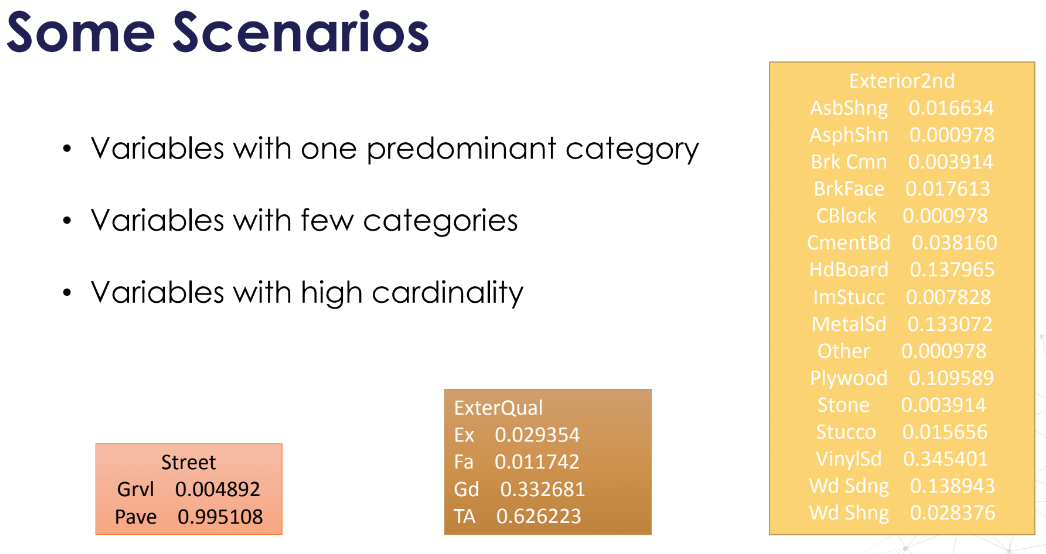

## Additional notes

**Note that grouping infrequent labels or categories under a new category called 'Rare' or 'Other' is the common practice in machine learning for business.**

* Grouping categories into rare for variables that show low cardinality may or may not improve model performance, however, we tend to re-group them into a new category to smooth model deployment.
* Grouping categories into rare for variables with high cardinality, tends to improve model performance as well.

**We will learn how to re-group rare labels under a new category called rare, and compare the implications of this encoding in variables with:**

* One predominant category
* A small number of categories
* High cardinality

**Important**

The identification of rare labels should be done using only the training set, and then propagated to the test set. Rare labels should be identified in the training set only. In practice, what we will do is identify non-rare labels, and then any other label, either in the train or the test or future live data that is not in that list of non-rare labels, will be re=grouped into the new category.

For example, let's imagine that we have in the training set the variable 'city' with the labels 'London', 'Manchester' and 'Yorkshire'. 'Yorkshire' is present in less than 5% of the observations so we decide to re-group it in a new category called 'Rare'.

In the test set, we should also replace 'Yorkshire' by 'Rare', regardless of the percentage of observations for 'Yorkshire' in the test set. In addition, if in the test set we find the category 'Milton Keynes', that was not present in the training set, we should also replace that category by 'Rare'. On other words, all categories present in test set, not present in the list of non-rare categories derived from the training set, should be treated as rare values and re-grouped into 'Rare'.

### Check Variables with one dominant category

In [ ]:
# let's explore a few examples in which variables have only a few categories, say less than 3
for col in X_train.columns:  # Step 1: Loop through each column in the dataset

    if X_train[col].dtypes == "O":  # Step 2: Check if the column is categorical (dtype "O" for object)

        if X_train[col].nunique() < 3:  # Step 3: Check if the column has fewer than 3 unique categories

            # Step 4: Calculate and print the percentage of observations per category
            # This prints the proportion of the total dataset that falls into each category
            print(X_train.groupby(col)[col].count() / len(X_train))
            print()  # Add an empty line for better readability of the output

### Check Variables with few categories

In [ ]:
# the columns in the below list have only 4 different labels
cols = ["MasVnrType", "ExterQual", "BsmtCond"]

for col in cols:  # Step 1: Loop through each column in the list

    # Step 2: Calculate and print the frequency of each category within the column
    # This divides the count of each category by the total number of observations
    print(X_train.groupby(col)[col].count() / len(X_train))  # frequency
    print()  # Step 3: Add an empty line for better readability of the output

### Check Variable with high cardinality


In [ ]:
# let's explore examples in which variables have several categories, say more than 10

# Step 1: Initialize an empty list to store columns with more than 10 categories
multi_cat_cols = []

# Step 2: Loop through each column in the dataset
for col in X_train.columns:

    # Step 3: Check if the column is categorical (dtype "O" for object)
    if X_train[col].dtypes == "O":

        # Step 4: Check if the column has more than 10 unique categories
        if X_train[col].nunique() > 10:

            # Step 5: Add the column name to the list
            multi_cat_cols.append(col)

            # Step 6: Calculate and print the frequency of each category within the column
            print(X_train.groupby(col)[col].count() / len(X_train))

            # Step 7: Add an empty line for better readability of the output
            print()

#### To visualize each column (Optional)

In [ ]:
for col in ["Neighborhood", "Exterior1st", "Exterior2nd"]:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color="red")
    fig.set_ylabel("Percentage of houses")
    plt.show()

## Encoding Rare Labels with Feature-Engine


In [ ]:
from feature_engine.encoding import RareLabelEncoder

# Step 1: Initialize RareLabelEncoder with specified parameters
# - tol: Percentage threshold to classify labels as rare
# - n_categories: Minimum number of categories required to apply rare label encoding
# - variables: List of columns to apply the encoding
rare_encoder = RareLabelEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=4,  # minimal number of categories the variable should have to re-group rare categories
    variables=[
        "Neighborhood",
        "Exterior1st",
        "Exterior2nd",
        "MasVnrType",
        "ExterQual",
        "BsmtCond",
    ],  # variables to re-group
)

# Step 2: Fit the encoder on the training data
# This calculates which categories are considered rare based on the given parameters
rare_encoder.fit(X_train)

# Step 3: Print the list of variables to which the encoder was applied
print(rare_encoder.variables)

# Step 4: Print the encoder dictionary that shows which labels were grouped
# into the 'rare' category for each variable
print(rare_encoder.encoder_dict_)

# Step 5: Transform the training and test data by grouping rare categories
# into a single category
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

# Additional Notes

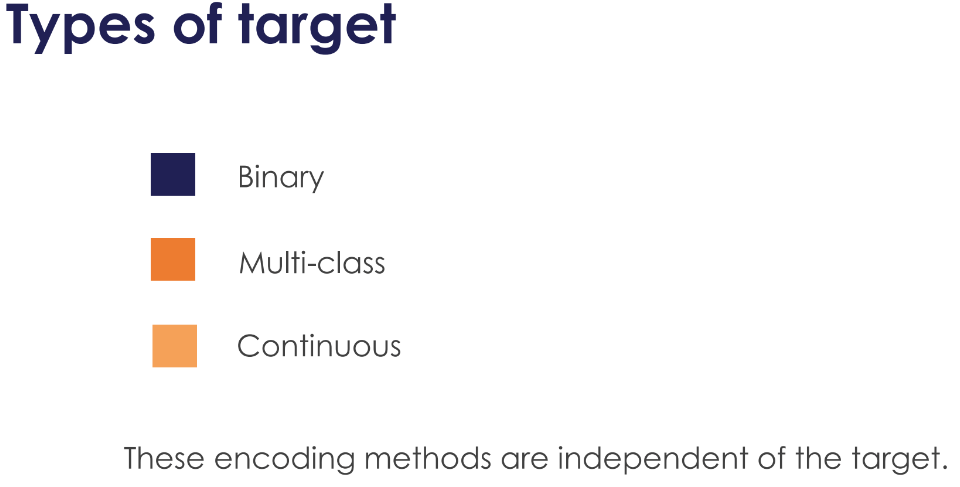

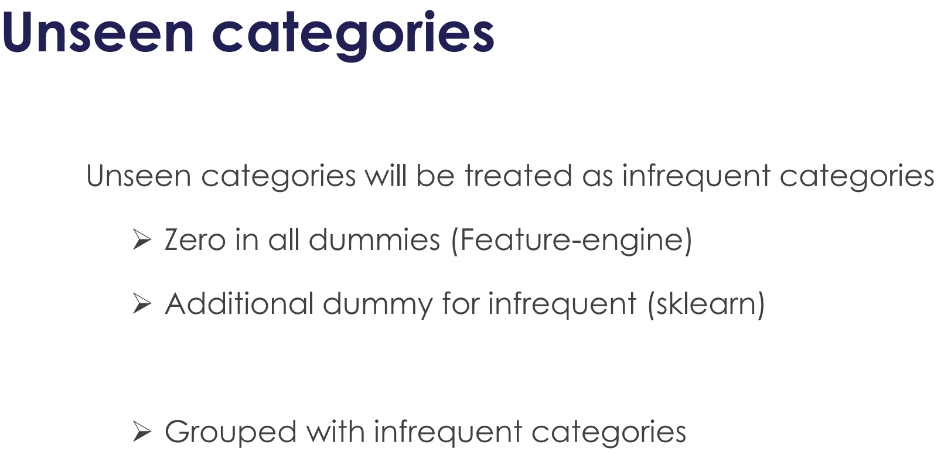

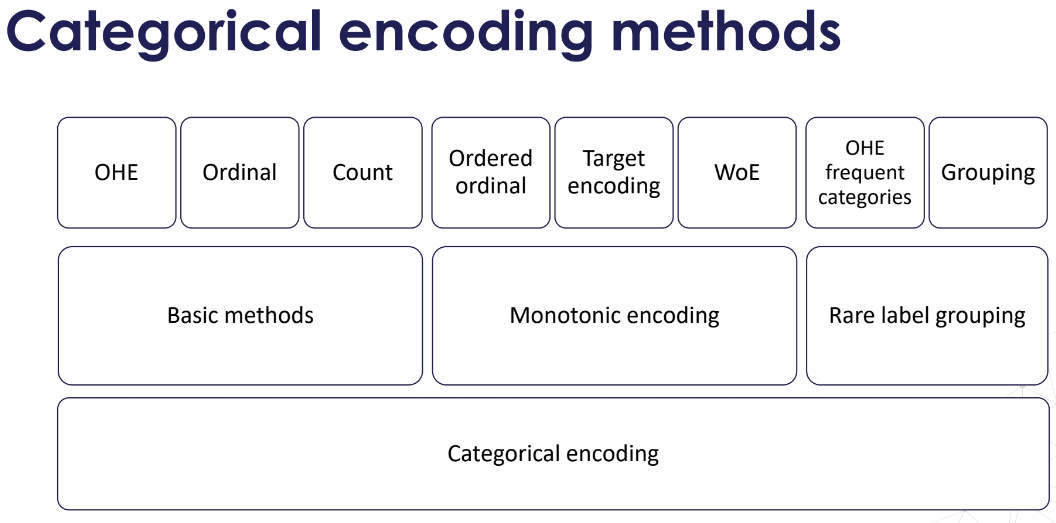